# 타이타닉 생존자 데이터 분석 Study

이번 블로그는 캐글 초보자를 위한 유명한 데이터 분석인 Titanic: Machine Learning from Disaster에 대한 블로깅일 할 것이다.

다음의 참고자료를 통해 재구성 한 것이다.

- [캐글 타이타닉 생존자 예측 도전기 (1)](https://cyc1am3n.github.io/2018/10/09/my-first-kaggle-competition_titanic.html)
- [seethefuture님 블로그](https://seethefuture.tistory.com/72)
- [이것이 데이터 분석이다 chpter.4](https://speedanddirection.tistory.com/64)

### 1. 데이터 분석을 위한 문제 정의하기

- 타이타닉호의 탑승 했던 사람들의 정보를 바탕으로 생존자를 예측하는 문제이다.
- 이 데이터를 분석하기 위해 여러가지 머신러닝 스킬들을 사용할 것이다.
- 그 당시 시대적인 배경(사회적 지위, lady first)에 따라 생존률에 영향을 미치는지 확인해 볼 것이다.

### 2. 데이터 불러오기


제일 먼저 필요한 라이브러리인 numpy와 pandas를 import 하고 필요한 데이터 파일을 불러오자.


In [150]:
import pandas as pd
import numpy as np

In [151]:
train = pd.read_csv('/home/jaeyoon89/kaggle_titanic_study/train.csv')
test = pd.read_csv('/home/jaeyoon89/kaggle_titanic_study/test.csv')

데이터가 제대로 불러와졌는지 확인을 위해 train.head()를 실행시키자.

In [152]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 3. 데이터 분석


- Survivied는 생존 여부(0은 사망, 1은 생존) -> train 데이터에서만 제공한다.
- Pclass는 사회경제적 지위(1에 가까울 수록 높다.)
- SipSp는 배우자나 형제 자매 명 수의 총 합을 나타낸다.
- Parch는 부모 자식 명 수의 총 합을 나타낸다.

각각 특성들의 의미를 알았으니, 주어진 데이터에서 대해 간략하게 살펴보자.

In [153]:
print('train data shape: ', train.shape)
print('test data shape: ', test.shape)
print('----------[train infomation]----------')
print(train.info())
print('----------[test infomation]----------')
print(test.info())

train data shape:  (891, 12)
test data shape:  (418, 11)
----------[train infomation]----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
----------[test infomation]----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):


그리고 PassengerId, Name, Ticke, Cabin 은 분석하기에 필요 없는 부분이라 생각해서 drop() 함수를 이용해 제거한다. 뒤에서 진행할 머신러닝에서 사용할 수 있게 숫자 변환하는 것이 어렵기 때문이다. Tiket과 PassengerId 생존율 분석에 의미가 없다고 판단하여 이것 또한 제거하자.

In [154]:
train = train.drop(['PassengerId','Name', 'Ticket','Cabin'], axis = 1 )
test = test.drop(['Name', 'Ticket','Cabin'], axis= 1)

이제 위에서 살펴본 특성들이 Survived 에 미치는 영향에 대해서 생각해보자.
먼저 데이터의 시각화를 위한 라이브러리를 불러오자.

In [155]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#### 3.1 Pie chart 


먼저 아래와 같이 카테고리 피처의 분포를 알아보기 위해 pie chart를 만드는 함수를 정의하자.

- Sex
- Pclass
- Embarked

In [156]:
def pie_chart(feature):
    feature_ratio = train[feature].value_counts(sort=False)
    feature_size = feature_ratio.size
    feature_index = feature_ratio.index
    survived = train[train['Survived'] == 1][feature].value_counts()
    dead = train[train['Survived'] == 0][feature].value_counts()
    
    plt.plot(aspect='auto')
    plt.pie(feature_ratio, labels=feature_index, autopct='%1.1f%%')
    plt.title(feature + '\'s ratio in total')
    plt.show()
    
    for i, index in enumerate(feature_index):
        plt.subplot(1, feature_size + 1, i + 1, aspect='equal')
        plt.pie([survived[index], dead[index]], labels=['Survivied', 'Dead'], autopct='%1.1f%%')
        plt.title(str(index) + '\'s ratio')
    
    plt.show()

먼저 Sex에 대한 Pie chart를 그려보자.


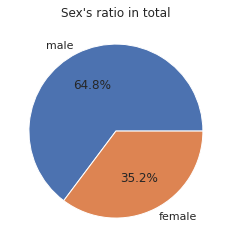

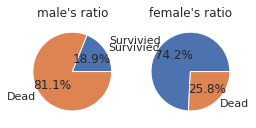

In [157]:
pie_chart('Sex')

위처럼 남성이 배에 더 많이 탔으며, 남성보다 여성의 생존율이 더 높다는 것을 알 수 있다. 당시 레이디퍼스트 라는 시대적인 개념이 있어 여자가 남성들 보다 높은 생존율을 보였다.

다음으로 Pclass에 대해서도 그려보자.

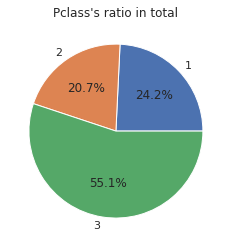

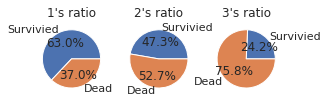

In [158]:
pie_chart('Pclass')

위처럼 탑승객들 중 3인 사람들이 가장 많이 탑승했지만 Pclass가 높은 사람들, 즉 사회적 지위가 높은 사람들의 생존율이 더 높다는 것을 알 수 있다.

마지막으로 어느 곳에서 승선했는지를 나타내는 Embarked 에 대해서도 알아보자.

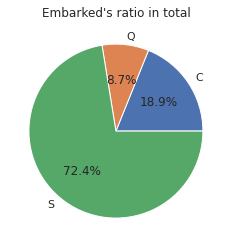

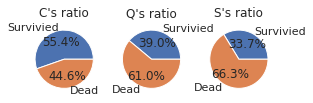

In [159]:
pie_chart('Embarked')

위와 같이 S에서 승선한 사람들이 가장 많았으며 C에서 탄 사람중에선 생존한 사람의 비율이 높았고, 나머지 두 선착장에서 탄 사람들은 생존하지 못한 사람이 더 많다.


앞서 Pclass,Sex,Embarked는 타이타닉을 탑승했던 사람들의 생존율에 의미있는 차트를 보인다. 

#### 3.2 Bar chart


이번에는 아래의 피처에 대해 Bar chart를 정의해서 데이터를 시각화 해보자.

- SibSp 
- Parch

In [160]:
def bar_chart(feature):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

먼저 SibSp에 대해 Bar chart를 그려보자.

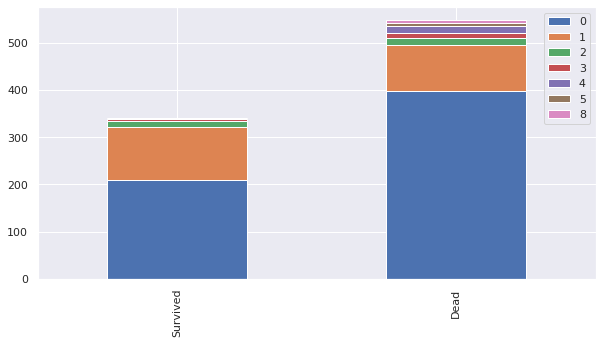

In [161]:
bar_chart("SibSp")

위 Bar chart 처럼 2명 이상의 형제나 배우자와 함께 탔을 경우 생존한 사람의 비율이 높다는 것을 알 수 있다.

이번엔 parch에 대해서도 Bar chart를 그려보자.

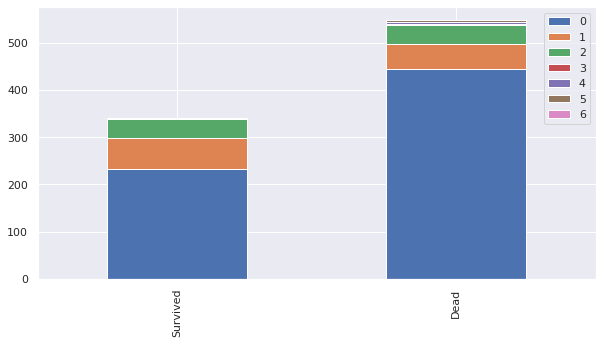

In [162]:
bar_chart("Parch")

Parch특성은 SibSp와 비슷한 결과를 보인다.

지금까지 살펴본 데이터 특성들을 보면 성별이 여성(영화에서 보면 여성과 아이들을 먼저 구명보트에 태우는 장면이 나온다.)이거나 Pclass(영화에서 배가 후미부터 잠기는데 등급이 높은방은 앞쪽에 있는 경향이 있어 그런듯 하다.) 가 높을수록 그리고 C 선착장에서 배를 타고 형제, 자매, 배우자, 부모, 자녀와 함께 배를 탄 사람들의 생존율이 높았다는 것을 알 수 있다.

하지만 하나의 특성과 생존 비율 만을 생각해서 예측하기에는 아직 무언가 부족하다.

예를 들어 높은 금액의 티켓을 산 부유한 사람이 가족들이랑 왔을 경우가 많다고 가정해본다면, 가족들과 함께 왔다고 해서 살 가능성이 높다고 할 수 없다. 따라서 단일 특성을 가지고 생존 확률을 예측하기보단 여러가지 특성을 종합해서 예측을 하는 것이 더 좋을 것이다.

### 4. 데이터 전처리 및 특성 추출하기

이제 앞으로 예측할 모델에 학습을 시킬 피처들을 골라 알맞게 전처리하는 과정을 해볼 것이다.

일단 우리가 선택할 특성은 Name, Sex, Embarked, Age, SibSp, Parch, Fare, Pclass이다. 하지만 Ticket과 Cabin은 특별히 데이터분석에 필요하지 않기 때문에 제외한다.

또한 데이터 전처리를 하는 과정에서는 train과 test 데이터를 같은 방법으로 한 번에 처리를 해야하기 때문에 먼저 두 개의 데이터를 합쳐보자.

In [272]:
train_and_test = [train, test]

#### 4.1 Name

이 피처는 위에서 제거하였다. 생존율 분석에 있어 크게 중요하지 않다고 판단하였다.

#### 4.2 Sex

이번엔 승객의 성별을 나타내는 Sex 피처를 처리해보자. 이미 male과 femal로 나누어져 있으며 String Data로 변경해 주면 된다.

In [163]:
for dataset in train_and_test:
    dataset['Sex'] = dataset['Sex'].astype(str)

#### 4.3 Embarked Feature

이제 배를 탑승한 선착장을 나타내는 Embarked 피처를 처리하자.
먼저 결측값이 있는지 확인을 해야 한다.

한편 위에서 보았던 Embarked 피처의 분포를 살펴보면 S가 대부분이다. 빠져있는 두 개의 데이터도 아마 거기에 속할 확률이 크기 때문에 S로 넣어주고 String Data로 변경해주자.

In [184]:
train['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [188]:
train["Embarked"].fillna('S', inplace=True)
test["Embarked"].fillna('S', inplace=True)

In [190]:
train['Embarked'].value_counts(dropna=False)

S    646
C    168
Q     77
Name: Embarked, dtype: int64

#### 4.3 Age

나이는 연속 데이터라 따로 처리가 필요 없지만 결측치를 처리해야 한다. 여기선 평균값으로 채우자. 데이터의 통일성을 가지기 위해 train 데이터셋의 평균값으로 test 데이터도 결측치를 채운다.

In [191]:
train["Age"].fillna(train["Age"].mean() , inplace=True)
test["Age"].fillna(train["Age"].mean() , inplace=True) 

#### 4.5 Fare

위에서 Test 데이터를 살펴보면 Fare 피처에도 결측값이 하나 존재한다. Pclass와 Fare가 어느정도 연관성이 있어보인다. 그래서 결측값에 Pclass를 가진 사람들의 평균 Fare를 넣어주도록 하자.

In [203]:
print(train[['Pclass', 'Fare']].groupby(['Pclass'], as_index=False).mean())
print("")
print(test[test["Fare"].isnull()]["Pclass"])

   Pclass       Fare
0       1  84.154687
1       2  20.662183
2       3  13.675550

152    3
Name: Pclass, dtype: int64


위 결과에서 보듯이 누락된 데이터의 Pclass는 3이고 평균값은 13.675550이므로 이 값을 넣어주자.

In [208]:
test["Fare"].fillna(13.675550, inplace=True)

#### 4.6 SibSp & Parch 

위에서 살펴 봤듯이 형제, 자매, 배우자, 부모님, 자녀의 수가 많을 수록 생존한 경우가 많았다. 하지만 이번에 그냥 있는 데이터로 진행해 보자.

#### 4.7 특성 추출 및 나머지 전처리 

이제 학습용 데이터를 위해 데이터를 분리하자.

In [209]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_female  891 non-null    uint8  
 7   Sex_male    891 non-null    uint8  
 8   Embarked_C  891 non-null    uint8  
 9   Embarked_Q  891 non-null    uint8  
 10  Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(5)
memory usage: 46.2 KB


In [210]:
train.head(5)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [211]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Age          418 non-null    float64
 3   SibSp        418 non-null    int64  
 4   Parch        418 non-null    int64  
 5   Fare         418 non-null    float64
 6   Sex_female   418 non-null    uint8  
 7   Sex_male     418 non-null    uint8  
 8   Embarked_C   418 non-null    uint8  
 9   Embarked_Q   418 non-null    uint8  
 10  Embarked_S   418 non-null    uint8  
dtypes: float64(2), int64(4), uint8(5)
memory usage: 21.8 KB


In [212]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,0,1,0,1,0
1,893,3,47.0,1,0,7.0000,1,0,0,0,1
2,894,2,62.0,0,0,9.6875,0,1,0,1,0
3,895,3,27.0,0,0,8.6625,0,1,0,0,1
4,896,3,22.0,1,1,12.2875,1,0,0,0,1


이제 결측치가 모두 채워졌다. 이제 사용할 Feature에 대해서는 전처리가 되었으니, 학습시킬때 제외시킬 Feature들을 Drop 시키자.

In [243]:
X_train = train.drop("Survived",axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId",axis=1).copy()

### 5. 모델 설계 및 학습

다음 6가지 머신러닝 모델을 사용해 보자.

- Logistic Regression
- Support Vector Machine (SVM)
- k-Nearest Neighbor (kNN)
- Random Forest
- SGD
- xgboost

위 모델을 사용하기 위한 scikit-learn 라이브러리를 불러오자.

In [264]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

# 경고메세지 제거
import warnings
warnings.filterwarnings(action='ignore') 

from sklearn.utils import shuffle

모델을 학습하기 전에 주어진 데이터가 정렬 되어 있으면 학습에 방해가 되므로 shuffle() 함수로 적절히 섞어주도록 하자.

In [265]:
X_train, Y_train = shuffle(X_train, Y_train, random_state = 5)

In [266]:
# 로지스틱 회귀 모델 사용

lr = LogisticRegression()
lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_test)

lr.score(X_train, Y_train)

0.8024691358024691

In [267]:
# Support Vector Machines 모델 사용

svc = SVC()

svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)

svc.score(X_train, Y_train)

0.6868686868686869

In [268]:
# Random Forests 모델 사용

random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

0.9820426487093153

In [269]:
# k-최근접 이웃 모델 사용
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

knn.score(X_train, Y_train)

0.8395061728395061

In [270]:
sgd = SGDClassifier(loss='log', max_iter=10, random_state=42)

sgd.fit(X_train, Y_train)

Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

0.7485970819304153

In [271]:
xgb  = XGBClassifier()
xgb.fit(X_train, Y_train)

Y_pred = xgb.predict(X_test)

xgb.score(X_train, Y_train)

[00:08:30] WARNING: /tmp/pip-build-gopfpmzp/xgboost/build/temp.linux-x86_64-3.6/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9629629629629629

결과를 보니 랜덤포레스트 모델을 사용하였을 때 가장 좋은 결과값이 나왔다. 요새 가장 각광 받고있는 모델인 xgboost 모델도 적용을 해 보았는데 랜덤 포레스트보다는 조금 떨어진 결과가 나왔지만 예측모델로서 나쁘지 않은 결과가 나왔다. 이번에 사용한 타이타닉 데이터는 랜덤포레스트 모델을 적용했을 때 더 잘 맞았던 것 같다.